# Data & Information quality assignment

TODO:
- perform data quality assesment using the following metrics:
    - completeness
- perform data imputation
- perform data quality assessment again:
    - completeness
    - accuracy
    
- perform ML quality analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import utility.dirty_completeness as dirty_completeness
import utility.utility as utility
import pandas_profiling as pp
import json as j
import utility.eff_apriori
import time


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

SEED = 122
N_ITER = 10  # <------------------- CHANGE HERE NUMBER OF ITERATIONS FOR ITERATIVE IMPUTATION METHOD.


plt.style.use('ggplot')

C:\Users\mvcim\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
soybean_df = pd.read_csv('../datasets/soybean.csv')
soybean_df.head()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class
0,october,normal,gt-norm,norm,yes,same-lst-yr,low-areas,pot-severe,none,90-100,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
1,august,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,severe,fungicide,80-89,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
2,july,normal,gt-norm,norm,yes,same-lst-yr,scattered,severe,fungicide,lt-80,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
3,july,normal,gt-norm,norm,yes,same-lst-yr,scattered,severe,none,80-89,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
4,october,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,pot-severe,none,lt-80,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker


## Exploratory analysis

Analyze the correlation between the columns of the target.

In [3]:
"""
!!!!!!! DECOMMENT THIS LINE TO CREATE THE REPORT.
"""

"""profile_soybean = pp.ProfileReport(soybean_df, title="Soybean profiling")
profile_soybean.to_file("../profilingReports/soybean_profiling.json")"""

'profile_soybean = pp.ProfileReport(soybean_df, title="Soybean profiling")\nprofile_soybean.to_file("../profilingReports/soybean_profiling.json")'

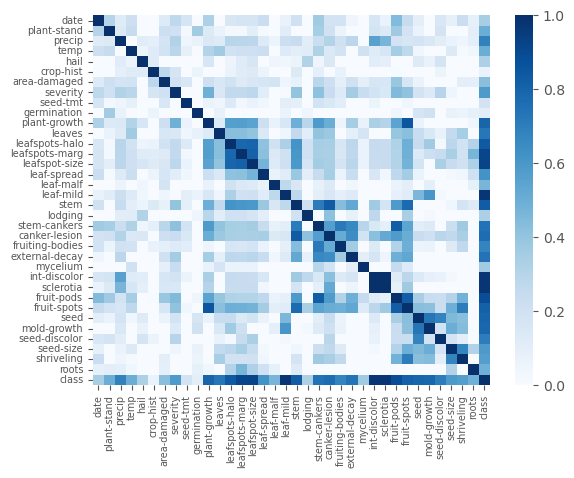

In [4]:
f = open("../profilingReports/soybean_profiling.json")
jfile = j.load(f)

labels = list(jfile["correlations"]["auto"][0].keys())

df_correlation = pd.DataFrame(jfile["correlations"]["auto"])
sns.heatmap(df_correlation, cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [62]:
high_correlated = [i for i, c in enumerate(df_correlation['class']) if c > 0.9]
high_correlated_labels = [soybean_df.columns[i] for i in high_correlated]
high_correlated_labels = high_correlated_labels[: -1]
high_correlated_labels

['leafspots-marg', 'leafspot-size', 'leaf-mild', 'int-discolor', 'sclerotia']

We notice that the class variable is highly correlated with:
- leafspots-marg
- leafspot-size
- leaf-mild
- int-discolor
- sclerotia

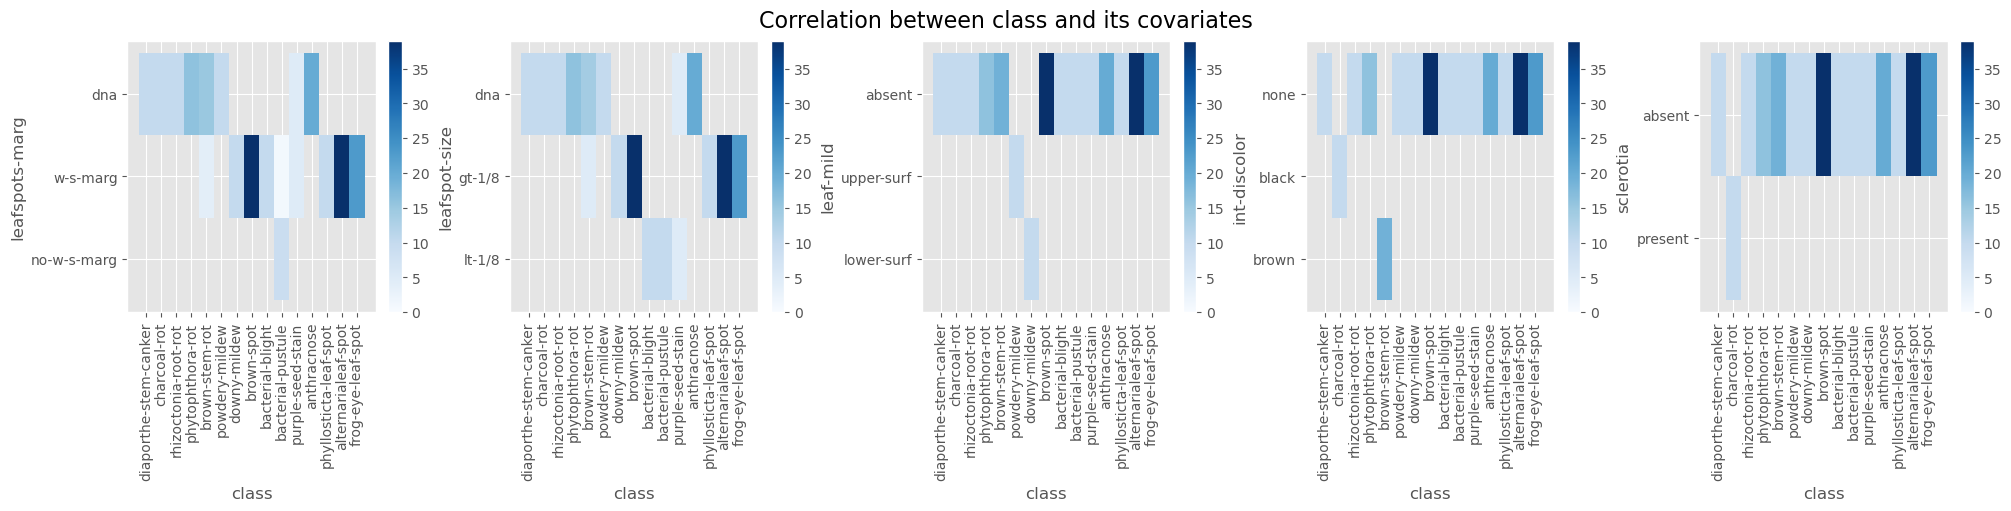

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=len(high_correlated_labels), figsize=(20, 5), constrained_layout=True)

fig.suptitle('Correlation between class and its covariates', fontsize=16)

for a, l in zip(axs, high_correlated_labels):
    sns.histplot(soybean_df, x='class', y=l, alpha=1, ax=a, cbar=True, cmap='Blues')
    a.tick_params('x', labelrotation=90, labelsize=10)
    a.tick_params('y', labelsize=10)

plt.show()

From these plots, we notice that the correlation is given by the fact that it is almost always possible to determine the value of variables 'leafspots-marg', 'leafspot-size', 'leaf-mild', 'int-discolor', 'sclerotia' starting from the class variable.\
The contrary is not true, thus we can not use the former variables to predict class, but we can use 'class' to make imputation on them.



In [68]:
sclerotia_correlated_idx = df_correlation['sclerotia'].loc[df_correlation['sclerotia'] > 0.9].index.values
sclerotia_correlated = [df_correlation.columns[i] for i in sclerotia_correlated_idx if df_correlation.columns[i] not in ['sclerotia', 'class']]
sclerotia_correlated

['int-discolor']

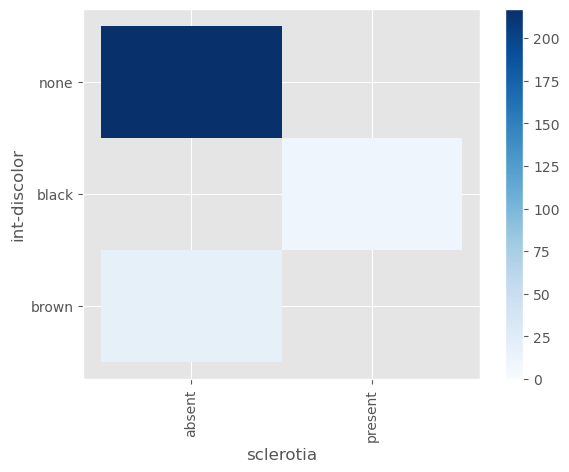

In [75]:
sns.histplot(soybean_df, x='sclerotia', y=sclerotia_correlated[0], alpha=1, cbar=True, cmap='Blues')
plt.xticks(rotation=90)
plt.show()

Since we do not have any domain knowledge, we can not use these information to make any functional dependency based imputation, instead, for each incomplete dataset we should perform the same procedure for detecting any functional dependency, otherwise, our imputation would be biased on the fact that we know the original dataset (not true in a real world scenario).\
As functional dependencies are out of scope of this project (and for simplicity sake) we will skip this procedure, even though it may bring to better results.

Plot the distribution of the target variable.\
The distribution of the classes is unbalanced.

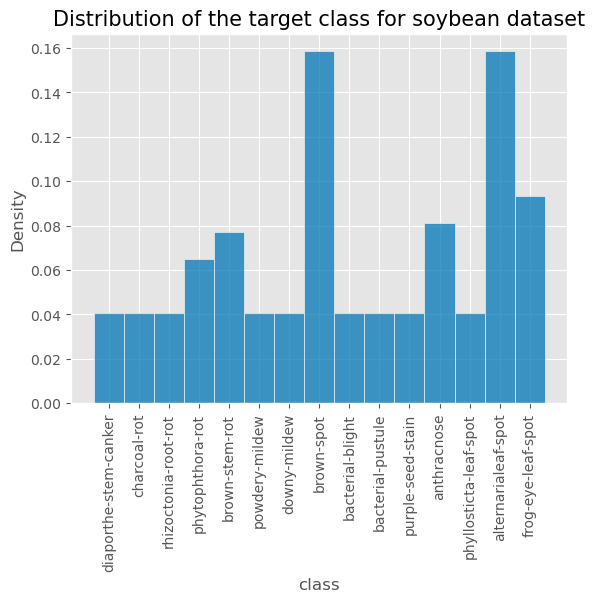

In [57]:
sns.histplot(soybean_df['class'], color='#0077b6', stat="density")
# soybean_df['class'].hist(bins=15, density=True)
plt.xticks(rotation=90)
plt.title('Distribution of the target class for soybean dataset', fontsize=15)
plt.show()

Duplicated analysis on the original data.

In [8]:
soybean_df[soybean_df.duplicated(keep='first')].shape[0]

3

In [9]:
soybean_df[soybean_df.duplicated(keep='first')]


,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class
47,august,normal,lt-norm,norm,yes,same-lst-yr,whole-field,pot-severe,fungicide,lt-80,...,absent,norm,absent,norm,absent,absent,norm,absent,norm,brown-stem-rot
111,may,lt-normal,gt-norm,norm,yes,same-lst-two-yrs,whole-field,pot-severe,none,lt-80,...,absent,norm,absent,norm,absent,absent,norm,absent,norm,brown-spot
194,october,normal,gt-norm,gt-norm,yes,same-lst-sev-yrs,whole-field,minor,fungicide,80-89,...,absent,norm,absent,norm,absent,absent,norm,absent,norm,alternarialeaf-spot


In the original data, there are 3 duplicated rows. We can not drop them, because we need all the rows during the data quality assesment after the imputation.\
By matter of fact, once we got the incomplete versions of the original dataset, and after applying the imputation technique, we may generate new duplicates(example 1) or we may loose some original duplicates(example2).

Example1:


|Tuple|$x_0$|$x_1$|$x_2$|$x_3$|$x_4$|
|---|---|---|---|---|---|
|Original tuple 1|0|<span style="color: red;">4</span>|3|2|7|
|Original tuple 2|0|<span style="color: red;">8</span>|3|2|7|
|Incomplete tuple 1|0|4|3|2|7|
|Incomplete tuple 2|0|<span style="color: red;">np.NaN</span>|3|2|7|
|Imputed tuple 1|0|<span style="color: red;">4</span>|3|2|7|
|Imputed tuple 2|0|<span style="color: red;">4</span>|3|2|7|

Assuming that we use a simple imputation tecnique using the mode to fill NaN values, and assuming the mode of $x_1$ is 4, 
we have generated a duplicate, that in the original dataset does not exist.

Example2:


|Tuple|$x_0$|$x_1$|$x_2$|$x_3$|$x_4$|
|---|---|---|---|---|---|
|Original tuple 1|0|<span style="color: red;">4</span>|3|2|7|
|Original tuple 2|0|<span style="color: red;">4</span>|3|2|7|
|Incomplete tuple 1|0|4|3|2|7|
|Incomplete tuple 2|0|<span style="color: red;">np.NaN</span>|3|2|7|
|Imputed tuple 1|0|<span style="color: red;">4</span>|3|2|7|
|Imputed tuple 2|0|<span style="color: red;">8</span>|3|2|7|

Assuming that we use a simple imputation tecnique using the mode to fill NaN values, and assuming the mode of $x_1$ is 8, 
tuple1 and tuple2 are no more duplicated tuples. In a real world scenario, the process generating the data, may generate duplicates that we are not able to recognize due to thei missing values, so we have to consider also this fact when performing the accuracy assesment.

Since in this notebook we want to perform a data accuracy assesment after the imputation technique, we can not remove duplicates before the assesment, otherwise we may loose some inaccurate imputations.
Only once we have performed the accuracy assesment, we can drop the duplicates.

In [10]:
soybean_df.nunique()

date                7
plant-stand         2
precip              3
temp                3
hail                2
crop-hist           4
area-damaged        4
severity            3
seed-tmt            3
germination         3
plant-growth        2
leaves              2
leafspots-halo      3
leafspots-marg      3
leafspot-size       3
leaf-spread         2
leaf-malf           2
leaf-mild           3
stem                2
lodging             2
stem-cankers        4
canker-lesion       4
fruiting-bodies     2
external-decay      2
mycelium            2
int-discolor        3
sclerotia           2
fruit-pods          3
fruit-spots         4
seed                2
mold-growth         2
seed-discolor       2
seed-size           2
shriveling          2
roots               3
class              15
dtype: int64

From the [Dataset documentation](https://archive.ics.uci.edu/ml/datasets/Soybean+(Large)) we can look at the values each variable can take. We can deduce that almost all the variables are categorical.\
Features that are not categorical are:

cyclic features:
- date

ordinal features:
- plant-stand
- precip
- temp
- germination


## Injection of null values.

In [3]:
df_s = dirty_completeness.injection(soybean_df, SEED, name='', name_class='class')

saved -completeness50%
saved -completeness60%
saved -completeness70%
saved -completeness80%
saved -completeness90%


## Data quality assessment before the imputation.

In this section, first we make a data quality assesment.

In [12]:
X_columns = list(soybean_df.columns.values)
X_columns.remove('class')

In [13]:
completeness_degree = [1 - df[X_columns].isnull().sum().sum() / (df[X_columns].shape[0] * df[X_columns].shape[1]) for df in df_s]
completeness_degree

[0.4979919678714859,
 0.5994262765347103,
 0.6953528399311533,
 0.7990820424555365,
 0.9016637980493403]

## Imputation
First, we try with a basic imputation method, then we try to use an ML method for imputation.
In both cases we perform an exact and similarity based post imputation assesment.

### Basic imputation method

Since there are a lot of categorical features, we believe a good basic imputation method could be to fill each NaN value with the mode of its belonging column.

In [15]:

def mode_imputation(df_s):
    imputed = []
    for n, df in enumerate(df_s):
        simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
        imputed_df = simple_imputer.fit_transform(df)
        imputed_df = pd.DataFrame(imputed_df, columns=df.columns)
        imputed.append(imputed_df)
    return imputed


In [16]:
imputed_df_s_basic = mode_imputation(df_s)

## Data quality assessment after the data imputation.

First, we check that the completeness is 1 for each dataframe after the imputation.

In [17]:
completeness_degree = [1 - df[X_columns].isnull().sum().sum() / (df[X_columns].shape[0] * df[X_columns].shape[1]) for df in imputed_df_s_basic]
print(f"The completeness degree for each impute dataframe is {completeness_degree}")

The completeness degree for each impute dataframe is [1.0, 1.0, 1.0, 1.0, 1.0]


Now, we compute the accuracy. First we mesure basic imputation using the exact matching.

In [18]:
exact_basic_assesment = utility.accuracy_assesment(imputed_df_s_basic, soybean_df, columns=X_columns)
exact_basic_assesment = list(exact_basic_assesment.values())
exact_basic_assesment

[0.858433734939759,
 0.8866577420794288,
 0.9132083891120035,
 0.9424364123159303,
 0.9721106648817492]

Check that there are no duplicates.

In [19]:
basic_imputation_duplicates = [df[df.duplicated(keep='first')].shape[0] for df in imputed_df_s_basic]
basic_imputation_duplicates

[7, 5, 1, 1, 2]

Note:
- starting from a dataframe with 50% incompleteness, after the imputation, for sure, we generated new duplicates.
- starting from a dataframe with 80% incompleteness, after the imputation, for sure, we have reduced the number of duplicates.

For the accuracy assesment based on the distance, we can convert the ordinal and cyclic variables to numerical values and mesure the accuracy based on the distance between their values.


Date is a cyclic variable, thus, we can transform it in a vector with the following components.


$x = to\_ordinal(date)$


$x = sin(\frac{2\pi}{12}x)$

$y = to\_ordinal(date)$


$y = cos(\frac{2\pi}{12}y)$

$date = \begin{bmatrix} x & y \end{bmatrix}$

In this way, no matter where we start to enumerate the months, close months will have similar representation.

From the [Dataset documentation](https://archive.ics.uci.edu/ml/datasets/Soybean+(Large)), the following ordinal features have the domain in the table:

| features | original domain | ordinal domain |
| --- | --- | --- |
|plant-stand|lt-norm, norm, gt-norm|0, 1, 2|
|precip|lt-norm, norm, gt-norm|0, 1, 2|
|temp|lt-norm, norm, gt-norm|0, 1, 2|
|germination|lt-80%, 80-89%, 90-100%|0, 1, 2|
|severity|minor, pot-severe, severe|0, 1, 2|


### Transformation of date in cyclic variable.

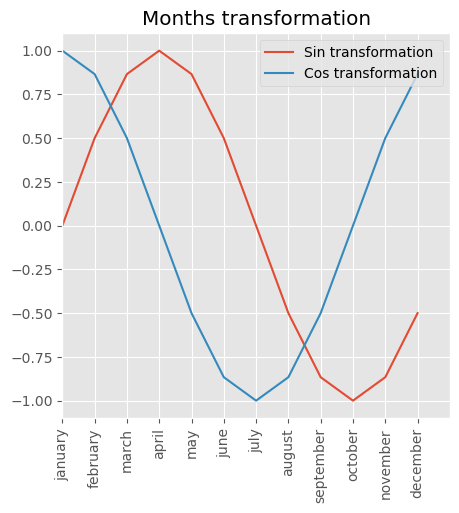

In [20]:
months = ['january',
          'february',
          'march',
          'april',
          'may',
          'june',
          'july',
          'august',
          'september', 
          'october',
          'november',
          'december']

period = 12
months_sin = [np.sin((2 * np.pi * i) / period) for i, _ in enumerate(months)]
months_cos = [np.cos((2 * np.pi * i) / period) for i, _ in enumerate(months)]

plt.figure(figsize=(5, 5))

plt.plot([i for i in range(len(months))], months_sin, label='Sin transformation')
plt.plot([i for i in range(len(months))], months_cos, label='Cos transformation')

plt.title('Months transformation')
plt.xticks([i for i in range(len(months))], months, rotation=90)
plt.xlim((0, 12))
plt.legend()

plt.show()

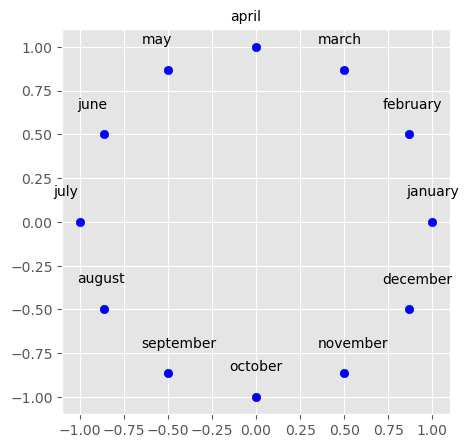

In [21]:
plt.figure(figsize=(5, 5))
for c, s, month in zip(months_cos, months_sin, months):
    plt.scatter(c, s, color='blue')
    plt.text(c-0.15,s+0.15,s=month)
    
plt.show()

Here we add a new column, month_cos_sin, which contain a tuple (cos, sin) corresponding to the month. This column is used for the accuracy assesment.

In [22]:
months_dict = {}

for c, s, m in zip(months_cos, months_sin, months):
    months_dict[m] = (c, s)

numeric_soybean = soybean_df.copy()

def convert_date_tuple(df_in):
    """
    This method creates a new dataframe starting from the one given in input.
    It adds a new column 'month_cos_sin' which contains tuples having as first element the cos part
    of the month and as second element the sin part of the month. It removes 'date' column.
    :param df_in: pandas dataframe reference.
    :return: new pandas dataframe.
    """
    df = df_in.copy()
    df['month_cos_sin'] = df.apply(lambda row: (months_dict[row['date']][0], months_dict[row['date']][1]), axis=1)
    df = df.drop(columns=['date'])
    return df


def convert_date(df_in):
    """
    This method creates a new dataframe starting from the one given in input.
    It adds two columns.
    First, it adds 'month_cos' column containing the cos part of the month.
    Second, it adds 'month_sin' column containing the sin part of the month.
    It removes 'date' column.
    :param df_in: pandas dataframe reference.
    :return: new pandas dataframe.
    """
    df = df_in.copy()
    df['month_cos'] = df.apply(lambda row: months_dict[row['date']][0], axis=1)
    df['month_sin'] = df.apply(lambda row: months_dict[row['date']][1], axis=1)
    df = df.drop(columns=['date'])
    return df
    
numeric_soybean = convert_date_tuple(numeric_soybean)

numeric_soybean

,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,plant-growth,...,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class,month_cos_sin
0,normal,gt-norm,norm,yes,same-lst-yr,low-areas,pot-severe,none,90-100,abnorm,...,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-1.8369701987210297e-16, -1.0)"
1,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,severe,fungicide,80-89,abnorm,...,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-0.8660254037844388, -0.4999999999999997)"
2,normal,gt-norm,norm,yes,same-lst-yr,scattered,severe,fungicide,lt-80,abnorm,...,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-1.0, 1.2246467991473532e-16)"
3,normal,gt-norm,norm,yes,same-lst-yr,scattered,severe,none,80-89,abnorm,...,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-1.0, 1.2246467991473532e-16)"
4,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,pot-severe,none,lt-80,abnorm,...,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker,"(-1.8369701987210297e-16, -1.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,normal,gt-norm,gt-norm,yes,same-lst-two-yrs,low-areas,minor,fungicide,80-89,norm,...,diseased,colored,norm,absent,absent,norm,absent,norm,frog-eye-leaf-spot,"(-0.5000000000000004, -0.8660254037844385)"
245,normal,gt-norm,norm,yes,same-lst-sev-yrs,scattered,pot-severe,none,90-100,norm,...,diseased,colored,norm,absent,absent,norm,absent,norm,frog-eye-leaf-spot,"(-0.5000000000000004, -0.8660254037844385)"
246,normal,gt-norm,norm,yes,same-lst-yr,upper-areas,pot-severe,none,80-89,norm,...,norm,absent,norm,absent,absent,norm,absent,norm,frog-eye-leaf-spot,"(-1.0, 1.2246467991473532e-16)"
247,normal,norm,gt-norm,yes,same-lst-sev-yrs,whole-field,minor,fungicide,90-100,norm,...,diseased,brown-w/blk-specks,abnorm,absent,present,lt-norm,present,norm,frog-eye-leaf-spot,"(-1.8369701987210297e-16, -1.0)"


### Transoformation of ordinal variables.

| features | original domain | ordinal domain |
| --- | --- | --- |
|plant-stand|lt-norm, norm, gt-norm|0, 1, 2|
|precip|lt-norm, norm, gt-norm|0, 1, 2|
|temp|lt-norm, norm, gt-norm|0, 1, 2|
|germination|lt-80%, 80-89%, 90-100%|0, 1, 2|
|severity|minor, pot-severe, severe|0, 1, 2|

In [23]:
ordinal_variables = ['plant-stand', 'precip', 'temp', 'germination', 'severity']

def to_ordinal(df_in):
    """
    Converts ordinal variables into numeric.
    """
    df = df_in.copy()
    
    ordinal_values = {
        "lt-norm": 0,
        "norm": 1,
        "gt-norm": 2,
        "lt-normal": 0,
        "normal": 1,
        "gt-normal": 2,
        "lt-80": 0,
        "80-89": 1,
        "90-100": 2,
        "minor": 0,
        "pot-severe":1,
        "severe": 2
    }

    for v in ordinal_variables:
        df[v] = df.apply(lambda row: ordinal_values[row[v]], axis=1)
    return df
        
def convert_for_assesment(df_in):
    """
    Prepares new dataframe having the variables transformed for an accuracy assesment based on distance.
    """
    df = df_in.copy()
    df = to_ordinal(df)
    df = convert_date_tuple(df)
    return df

In [24]:
numeric_soybean_df = convert_for_assesment(soybean_df)
numeric_imputed_basic = [convert_for_assesment(i) for i in imputed_df_s_basic]

X_columns = list(numeric_soybean_df.columns.values)
X_columns.remove('class')

distance_basic_assesment = utility.accuracy_assesment(numeric_imputed_basic,
                                                     numeric_soybean_df,
                                                     columns=X_columns,
                                                     numeric_columns=ordinal_variables,
                                                     vector_columns=['month_cos_sin'])
distance_basic_assesment = list(distance_basic_assesment.values())
distance_basic_assesment

[0.8780736901922422,
 0.9022448049826346,
 0.9236120404115572,
 0.9514789567553407,
 0.9759200261397846]

Using distances between numerical variables, the accuracy for the assesment increases with respect to an exact assesment.

### Advanced method
In this section, we perform a Multiple Imputation by Chained Equations technique, using a KNN model.

In [25]:
missing_columns = list(soybean_df.columns.values)
missing_columns.remove('class')

imputed_df_s_advanced = [utility.iterative_imputation_KNN(d, 'class', n_iter=N_ITER) for d in df_s]
exact_advanced_assesment = utility.accuracy_assesment(imputed_df_s_advanced, soybean_df, missing_columns)

loading: [===============] 100.0%
loading: [===============] 100.0%
loading: [===============] 100.0%
loading: [===============] 100.0%
loading: [===============] 100.0%


In [26]:
exact_advanced_assesment = list(exact_advanced_assesment.values())
exact_advanced_assesment

[0.8836456938866577,
 0.9216867469879518,
 0.9477911646586346,
 0.963186077643909,
 0.9840473003123605]

Accuracy assesment based on distances

In [27]:
numeric_imputed_advanced = [convert_for_assesment(i) for i in imputed_df_s_advanced]

distance_advanced_assesment = utility.accuracy_assesment(numeric_imputed_advanced,
                                                         numeric_soybean_df,
                                                         columns=X_columns,
                                                         numeric_columns=ordinal_variables,
                                                         vector_columns=['month_cos_sin'])
distance_advanced_assesment = list(distance_advanced_assesment.values())
distance_advanced_assesment

[0.9023857174905345,
 0.936769799494858,
 0.9578526710119466,
 0.9713884738332919,
 0.9876390174501011]

In [28]:
advanced_imputed_duplicated = [df[df.duplicated(keep='first')].shape[0] for df in imputed_df_s_advanced]
advanced_imputed_duplicated

[31, 22, 18, 7, 9]

It seems with an iterative impuation approach, the number of duplicated tuples significantly increases.

Visualization of the assesment accuracy

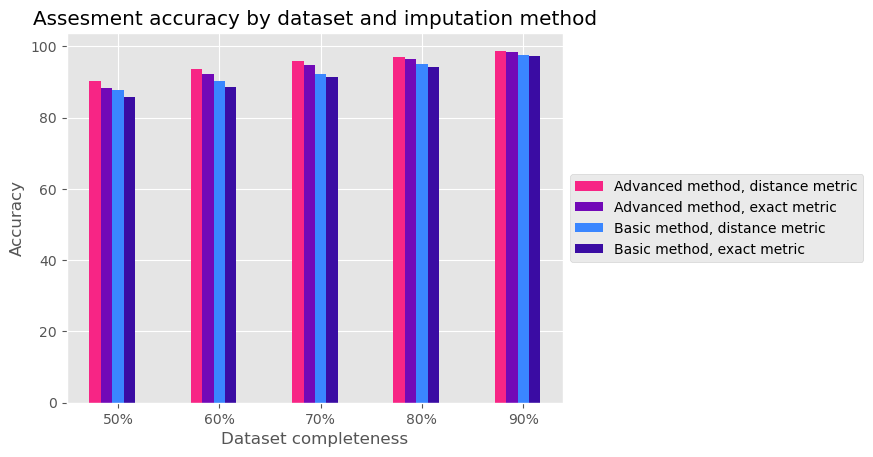

In [29]:
labels = [f'{p}%' for p in range(50, 100, 10)]

advanced_exact = np.array(exact_advanced_assesment) * 100
advanced_distance = np.array(distance_advanced_assesment) * 100

basic_exact = np.array(exact_basic_assesment) * 100
basic_distance = np.array(distance_basic_assesment) * 100

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, advanced_distance, width / 4, label='Advanced method, distance metric', color='#f72585')
rects2 = ax.bar(x - width/4, advanced_exact, width / 4, label='Advanced method, exact metric', color='#7209b7')
rects3 = ax.bar(x, basic_distance, width / 4, label='Basic method, distance metric', color='#3a86ff')
rects4 = ax.bar(x + width/4, basic_exact, width / 4, label='Basic method, exact metric', color='#3a0ca3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Dataset completeness')
ax.set_title('Assesment accuracy by dataset and imputation method')
ax.set_xticks(x, labels)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Predictions
Before making any prediction, we transform with one hot encoding the remaining categorical variables.

In [30]:
columns_to_categorical = list(soybean_df.columns.values)
columns_to_categorical.remove('class')
for o in ordinal_variables:
    columns_to_categorical.remove(o)
columns_to_categorical.remove('date')


In [31]:
def prepare_for_fit(df_in):
    df = df_in.copy()
    
    # transform categorical variables into one hot encoding.
    df = pd.get_dummies(df, columns=columns_to_categorical)
    
    # transform ordinal variables.
    df = to_ordinal(df)
    
    # transform cyclic variables.
    df = convert_date(df)
    return df

### Predictions with Decision Trees

Drop duplicates

In [32]:
imputed_df_s_basic = [df.drop_duplicates() for df in imputed_df_s_basic]
basic_imputation_duplicates = [df[df.duplicated(keep='first')].shape[0] for df in imputed_df_s_basic]
basic_imputation_duplicates

[0, 0, 0, 0, 0]

In [33]:
imputed_df_s_advanced = [df.drop_duplicates() for df in imputed_df_s_advanced]
advanced_imputation_duplicates = [df[df.duplicated(keep='first')].shape[0] for df in imputed_df_s_advanced]
advanced_imputation_duplicates

[0, 0, 0, 0, 0]

In [34]:
soybean_df = soybean_df.drop_duplicates()
soybean_df[soybean_df.duplicated(keep='first')].shape[0]

0

Transform data in the right format for training.

In [35]:
basic_df_transformed = [prepare_for_fit(d) for d in imputed_df_s_basic]
advanced_df_transformed = [prepare_for_fit(d) for d in imputed_df_s_advanced]


reference_soybean_transformed = prepare_for_fit(soybean_df)

Build models for each dataframe.

In [36]:
basic_accuracies = []
basic_reports = []
basic_confusion_matrixes = []
basic_weighted_f1_score = []


advanced_accuracies = []
advanced_reports = []
advanced_confusion_matrixes = []
advanced_weighted_f1_score = []

for d in basic_df_transformed:
    results = utility.pipeline_ML(d, 'class', SEED, utility.model_selection_decision_tree)
    basic_accuracies.append(results[1])
    basic_reports.append(results[2])
    basic_confusion_matrixes.append(results[3])
    basic_weighted_f1_score.append(results[4])
    
print('basic method tested')
    
for d in advanced_df_transformed:
    results = utility.pipeline_ML(d, 'class', SEED, utility.model_selection_decision_tree)
    advanced_accuracies.append(results[1])
    advanced_reports.append(results[2])
    advanced_confusion_matrixes.append(results[3])
    advanced_weighted_f1_score.append(results[4])
    
print('advanced method tested')

reference_results = utility.pipeline_ML(reference_soybean_transformed, 'class', SEED, utility.model_selection_decision_tree)
print('reference tested')

basic method tested
advanced method tested
reference tested


In [37]:
advanced_accuracies

[0.42424242424242425,
 0.5797101449275363,
 0.8142857142857143,
 0.7945205479452054,
 0.875]

In [38]:
basic_accuracies

[0.410958904109589, 0.4594594594594595, 0.56, 0.72, 0.8]

In [39]:
reference_results[1]

0.8513513513513513

### Accuracies comparison

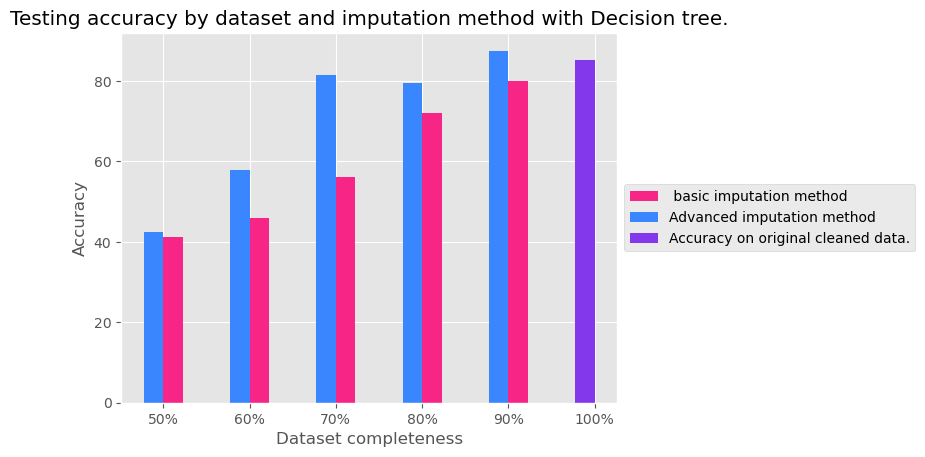

In [40]:
labels = [f'{p}%' for p in range(50, 110, 10)]

advanced_accuracies_plot = np.array(advanced_accuracies) * 100
basic_accuracies_plot = np.array(basic_accuracies) * 100

reference_accuracy_plot = reference_results[1] * 100

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x[:-1] + width/4, basic_accuracies_plot, width / 2, label=' basic imputation method', color='#f72585')
rects2 = ax.bar(x[: -1] - width/4, advanced_accuracies_plot, width / 2, label='Advanced imputation method', color='#3a86ff')

rect_reference = ax.bar(x[-1] - width/4, reference_accuracy_plot, width / 2, label='Accuracy on original cleaned data.', color='#8338ec')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Dataset completeness')
ax.set_title('Testing accuracy by dataset and imputation method with Decision tree.')
ax.set_xticks(x, labels)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### weigfhed f1 score comparison

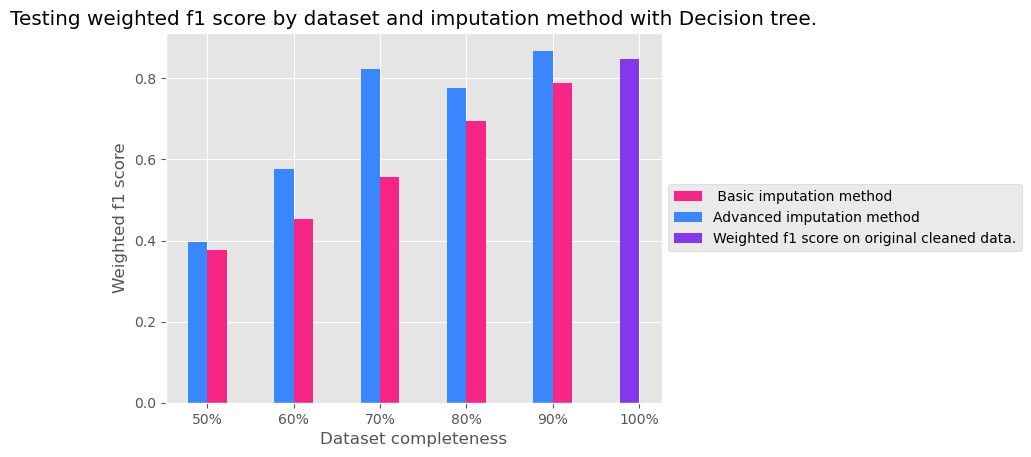

In [41]:
labels = [f'{p}%' for p in range(50, 110, 10)]

advanced_f1_plot = np.array(advanced_weighted_f1_score) 
basic_f1_plot = np.array(basic_weighted_f1_score) 

reference_f1_plot = reference_results[4] 

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x[:-1] + width/4, basic_f1_plot, width / 2, label=' Basic imputation method', color='#f72585')
rects2 = ax.bar(x[: -1] - width/4, advanced_f1_plot, width / 2, label='Advanced imputation method', color='#3a86ff')

rect_reference = ax.bar(x[-1] - width/4, reference_f1_plot, width / 2, label='Weighted f1 score on original cleaned data.', color='#8338ec')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weighted f1 score')
ax.set_xlabel('Dataset completeness')
ax.set_title('Testing weighted f1 score by dataset and imputation method with Decision tree.')
ax.set_xticks(x, labels)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Confusion matrices

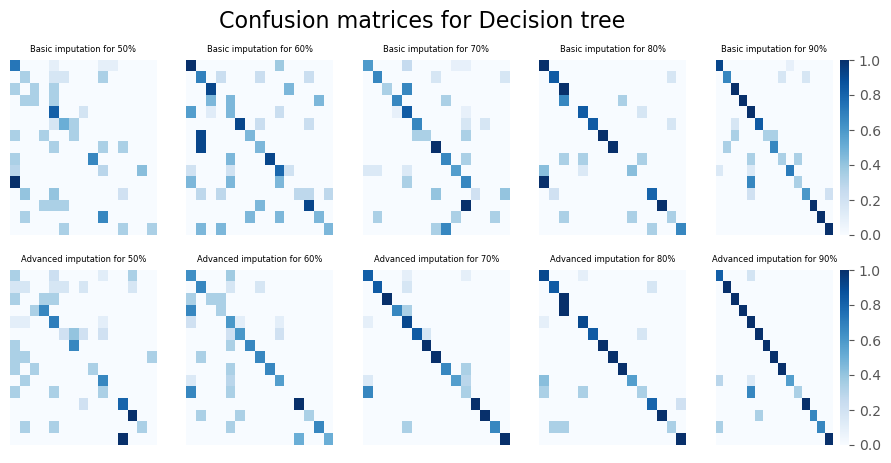

In [42]:
# plotting confusion matrices for basic and advanced methods.
sub_title_size = 6

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(11, 5))

fig.suptitle('Confusion matrices for Decision tree', fontsize=16)

for a, cm, p in zip(axs[0], basic_confusion_matrixes, range(50, 100, 10)):
    cbar = p == 90
    a.set_title(f"Basic imputation for {p}%", fontsize=sub_title_size)
    sns.heatmap(cm, annot=False, cmap='Blues', ax=a, yticklabels=False, xticklabels=False, cbar=cbar)
    
for a, cm, p in zip(axs[1], advanced_confusion_matrixes, range(50, 100, 10)):
    cbar = p == 90
    a.set_title(f"Advanced imputation for {p}%", fontsize=sub_title_size)
    sns.heatmap(cm, annot=False, cmap='Blues', ax=a, yticklabels=False, xticklabels=False, cbar=cbar)

plt.show()

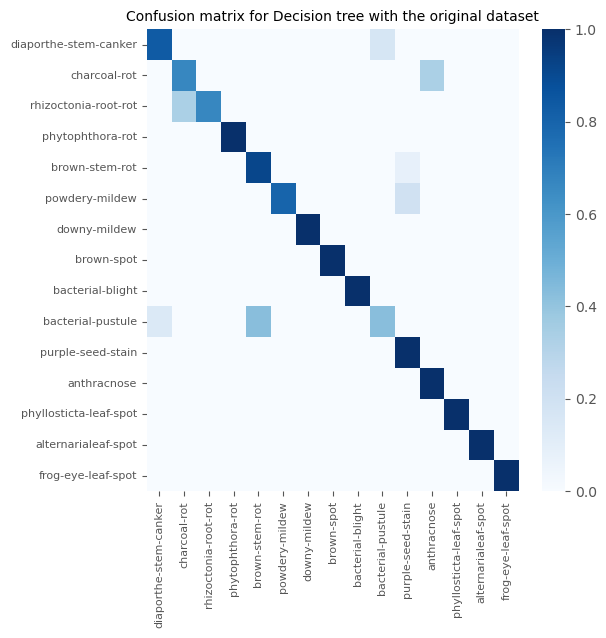

In [43]:
labels = soybean_df['class'].unique()
size = 6
plt.figure(figsize=(size, size))
plt.title('Confusion matrix for Decision tree with the original dataset', fontsize=10)

sns.heatmap(reference_results[3], cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.show()

## Prediction with SVM

In [44]:
basic_accuracies_svm = []
basic_reports_svm = []
basic_confusion_matrixes_svm = []
basic_weighted_f1_score_svm = []

advanced_accuracies_svm = []
advanced_reports_svm = []
advanced_confusion_matrixes_svm = []
advanced_weighted_f1_score_svm = []

for d in basic_df_transformed:
    results = utility.pipeline_ML(d, 'class', SEED, utility.model_selection_decision_tree)
    basic_accuracies_svm.append(results[1])
    basic_reports_svm.append(results[2])
    basic_confusion_matrixes_svm.append(results[3])
    basic_weighted_f1_score_svm.append(results[4])
    
print('basic method tested')
    
for d in advanced_df_transformed:
    results = utility.pipeline_ML(d, 'class', SEED, utility.model_selection_decision_tree)
    advanced_accuracies_svm.append(results[1])
    advanced_reports_svm.append(results[2])
    advanced_confusion_matrixes_svm.append(results[3])
    advanced_weighted_f1_score_svm.append(results[4])
    
print('advanced method tested')

reference_results_svm = utility.pipeline_ML(reference_soybean_transformed, 'class', SEED, utility.model_selection_SVM)
print('reference tested')

basic method tested
advanced method tested
reference tested


In [45]:
basic_accuracies_svm

[0.4383561643835616,
 0.44594594594594594,
 0.6133333333333333,
 0.6933333333333334,
 0.7466666666666667]

In [46]:
advanced_accuracies_svm

[0.5, 0.6231884057971014, 0.8, 0.821917808219178, 0.8888888888888888]

In [47]:
reference_results_svm[1]

0.9459459459459459

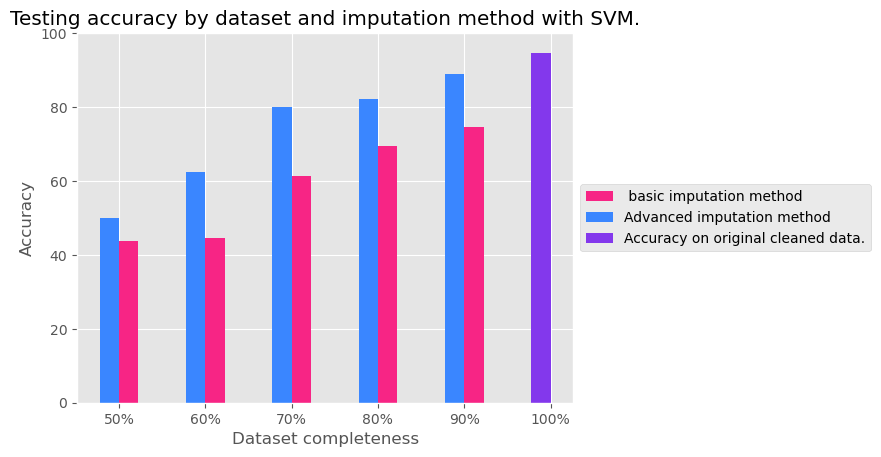

In [48]:
labels = [f'{p}%' for p in range(50, 110, 10)]

advanced_accuracies_plot = np.array(advanced_accuracies_svm) * 100
basic_accuracies_plot = np.array(basic_accuracies_svm) * 100

reference_accuracy_plot = reference_results_svm[1] * 100

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x[:-1] + width/4, basic_accuracies_plot, width / 2, label=' basic imputation method', color='#f72585')
rects2 = ax.bar(x[: -1] - width/4, advanced_accuracies_plot, width / 2, label='Advanced imputation method', color='#3a86ff')

rect_reference = ax.bar(x[-1] - width/4, reference_accuracy_plot, width / 2, label='Accuracy on original cleaned data.', color='#8338ec')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Dataset completeness')
ax.set_title('Testing accuracy by dataset and imputation method with SVM.')
ax.set_xticks(x, labels)
plt.ylim((0, 100))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Weighted f1 score SVM

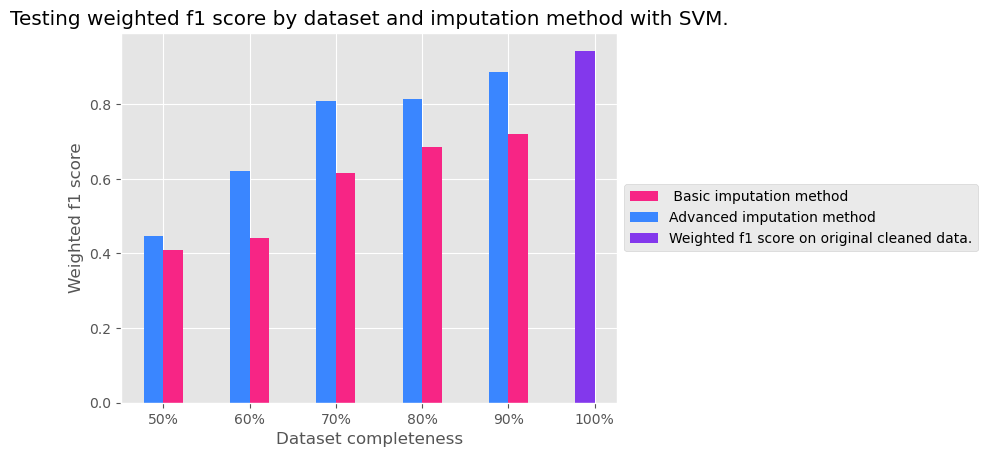

In [49]:
labels = [f'{p}%' for p in range(50, 110, 10)]

advanced_f1_plot = np.array(advanced_weighted_f1_score_svm) 
basic_f1_plot = np.array(basic_weighted_f1_score_svm) 

reference_f1_plot = reference_results_svm[4] 

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x[:-1] + width/4, basic_f1_plot, width / 2, label=' Basic imputation method', color='#f72585')
rects2 = ax.bar(x[: -1] - width/4, advanced_f1_plot, width / 2, label='Advanced imputation method', color='#3a86ff')

rect_reference = ax.bar(x[-1] - width/4, reference_f1_plot, width / 2, label='Weighted f1 score on original cleaned data.', color='#8338ec')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weighted f1 score')
ax.set_xlabel('Dataset completeness')
ax.set_title('Testing weighted f1 score by dataset and imputation method with SVM.')
ax.set_xticks(x, labels)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

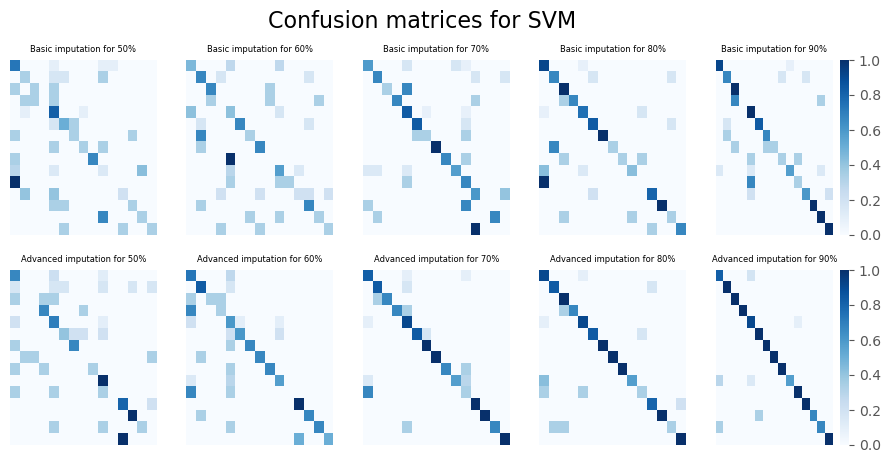

In [50]:
# plotting confusion matrices for basic and advanced methods.
sub_title_size = 6

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(11, 5))

fig.suptitle('Confusion matrices for SVM', fontsize=16)

for a, cm, p in zip(axs[0], basic_confusion_matrixes_svm, range(50, 100, 10)):
    cbar = p == 90
    a.set_title(f"Basic imputation for {p}%", fontsize=sub_title_size)
    sns.heatmap(cm, annot=False, cmap='Blues', ax=a, yticklabels=False, xticklabels=False, cbar=cbar)
    
for a, cm, p in zip(axs[1], advanced_confusion_matrixes_svm, range(50, 100, 10)):
    cbar = p == 90
    a.set_title(f"Advanced imputation for {p}%", fontsize=sub_title_size)
    sns.heatmap(cm, annot=False, cmap='Blues', ax=a, yticklabels=False, xticklabels=False, cbar=cbar)

plt.show()

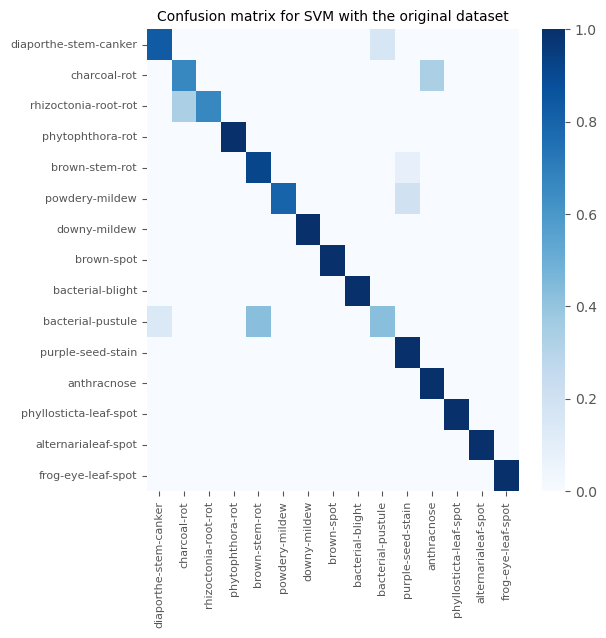

In [51]:
labels = soybean_df['class'].unique()
size = 6
plt.figure(figsize=(size, size))
plt.title('Confusion matrix for SVM with the original dataset', fontsize=10)

sns.heatmap(reference_results[3], cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.show()